# 实验准备

In [1]:
import numpy as np
from mlxtend.data import loadlocal_mnist
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.transforms as T
from collections import OrderedDict

In [2]:
# 如果计算机安装有CUDA，则使用CUDA进行接下来的全部训练，否则使用CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cuda


In [3]:
class MnistDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        image = self.images[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


# 加载数据集
train_images_path = '../data/train-images.idx3-ubyte'
train_labels_path = '../data/train-labels.idx1-ubyte'
test_images_path = '../data/t10k-images.idx3-ubyte'
test_labels_path = '../data/t10k-labels.idx1-ubyte'

# 读取训练数据
X_train, y_train = loadlocal_mnist(
    images_path=train_images_path,
    labels_path=train_labels_path)
# 调整图像形状
X_train = X_train.reshape(-1, 28, 28, 1)

# 将训练数据划分为训练集和验证集，固定划分（8:2）
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 读取测试数据，即测试集
X_test, y_test = loadlocal_mnist(
    images_path=test_images_path,
    labels_path=test_labels_path)
# 调整图像形状
X_test = X_test.reshape(-1, 28, 28, 1)

print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_val: ', X_val.shape)
print('y_val: ', y_val.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

# 将训练集、验证集、测试集分别包装为Dataloader
transform = T.Compose([T.ToTensor(), T.Normalize((0.1307,), (0.3081,))])

train_dataset = MnistDataset(X_train, y_train, transform=transform)
val_dataset = MnistDataset(X_val, y_val, transform=transform)
test_dataset = MnistDataset(X_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

X_train:  (48000, 28, 28, 1)
y_train:  (48000,)
X_val:  (12000, 28, 28, 1)
y_val:  (12000,)
X_test:  (10000, 28, 28, 1)
y_test:  (10000,)


# 寻找最佳超参数组合

In [4]:
# 检查模型准确率（使用验证集或测试集）
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        return acc

In [5]:
# 训练分类器
def train_classifier(model, optimizer, epochs):
    model = model.to(device=device)
    for e in range(epochs):
        for t, (x, y) in enumerate(train_loader):
            model.train()
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # 将待更新参数的梯度置为零
            optimizer.zero_grad()

            # 反向传播，计算梯度
            loss.backward()

            # 利用梯度更新参数
            optimizer.step()
            
    acc = check_accuracy(val_loader, model)
    return acc

In [6]:
# 定义过渡层
class _Transition(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.add_module('norm', nn.BatchNorm2d(in_channels))
        self.add_module('relu', nn.ReLU(inplace=True))

        self.add_module('conv', nn.Conv2d(in_channels, out_channels, 1, bias=False))
        self.add_module('pool', nn.AvgPool2d(2, 2))


# 定义稠密层        
class _DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate, bottleneck_size, dropout):
        super().__init__()

        self.norm1 = nn.BatchNorm2d(in_channels) 
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, growth_rate * bottleneck_size, 1, bias=False)

        self.norm2 = nn.BatchNorm2d(growth_rate * bottleneck_size)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(growth_rate * bottleneck_size, growth_rate, 3, padding=1, bias=False)
        
        self.dropout = nn.Dropout(p=dropout)  # 添加Dropout层

    def forward(self, x):
        x = [x] if torch.is_tensor(x) else x
        x = self.conv1(self.relu1(self.norm1(torch.cat(x, 1))))
        x = self.conv2(self.relu2(self.norm2(x)))
        output = self.dropout(x)

        return output
    
    
# 定义稠密块
class _DenseBlock(nn.ModuleDict):
    def __init__(self, num_layers, in_channels, growth_rate, bottleneck_size, dropout):
        super().__init__()

        for i in range(num_layers):
            layer = _DenseLayer(in_channels + i * growth_rate, growth_rate, bottleneck_size, dropout)
            self.add_module(f'denselayer{i+1}', layer)
              
    def forward(self, x):
        xs = [x]

        for name, layer in self.items():
            x_new = layer(xs)
            xs.append(x_new)

        return torch.cat(xs, 1)
      
      
class DenseNet(nn.Module):
    def __init__(self, block_config, growth_rate=16, bottleneck_size=4, num_classes=10, dropout=0.0):
        super(DenseNet, self).__init__()

        in_channels = 2 * growth_rate
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(1, in_channels, 7, padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(in_channels)),
            ('relu0', nn.ReLU(inplace=True)),
        ]))
        
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers, in_channels, growth_rate, bottleneck_size, dropout)
            self.features.add_module(f'denseblock{i+1}', block)
            in_channels += num_layers * growth_rate
            
            if i != len(block_config) - 1:
                trans = _Transition(in_channels, in_channels // 2)
                self.features.add_module(f'transition{i+1}', trans)
                in_channels = in_channels // 2
            
        self.features.add_module(f'norm{i+2}', nn.BatchNorm2d(in_channels))
        self.features.add_module(f'relu{i+2}', nn.ReLU(inplace=True))

        self.classifier = nn.Linear(in_channels, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)
                
    def forward(self, x):
        x = F.adaptive_avg_pool2d(self.features(x), (1, 1))
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

In [7]:
# SGD as optimizer
best_model = None
best_val_acc = -1
best_lr = -1
best_momentum = -1

opt = "SGD"
learning_rates = [5e-3, 6e-3]
momentums = [0.9, 0.95]
weight_decay = 0.0001
dropout = 0.2

for lr in learning_rates:
    for momentum in momentums:
        model = DenseNet(block_config=[6, 12, 24, 16], dropout=dropout)
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=True, weight_decay=weight_decay)
        val_acc = train_classifier(model, optimizer, epochs=10)
        if val_acc > best_val_acc:
            best_model = model
            best_val_acc = val_acc
            best_lr = lr
            best_momentum = momentum
        print('optimizer %s lr %e momentum %e weight_decay %e val accuracy: %f' % (opt, lr, momentum, weight_decay, val_acc))
            
print('best validation accuracy achieved:')
print('optimizer %s lr %e momentum %e weight_decay %e val accuracy: %f' % (opt, best_lr, best_momentum, weight_decay, best_val_acc))
# optimizer SGD lr 5.000000e-03 momentum 9.500000e-01 weight_decay 1.000000e-04 val accuracy: 0.993917 test accuracy: 0.994300

optimizer SGD lr 5.000000e-03 momentum 9.000000e-01 weight_decay 1.000000e-04 val accuracy: 0.987500
optimizer SGD lr 5.000000e-03 momentum 9.500000e-01 weight_decay 1.000000e-04 val accuracy: 0.992917
optimizer SGD lr 6.000000e-03 momentum 9.000000e-01 weight_decay 1.000000e-04 val accuracy: 0.990500
optimizer SGD lr 6.000000e-03 momentum 9.500000e-01 weight_decay 1.000000e-04 val accuracy: 0.992333
best validation accuracy achieved:
optimizer SGD lr 5.000000e-03 momentum 9.500000e-01 weight_decay 1.000000e-04 val accuracy: 0.992917


In [7]:
# Adam as optimizer
best_model = None
best_val_acc = -1
best_lr = -1

opt = "Adam"
learning_rates = [1e-5, 5e-5, 2e-4]
weight_decay = 0.0001
dropout = 0.0

for lr in learning_rates:
    model = DenseNet(block_config=[6, 12, 24, 16], dropout=dropout)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    val_acc = train_classifier(model, optimizer, epochs=10)
    if val_acc > best_val_acc:
        best_model = model
        best_val_acc = val_acc
        best_lr = lr
    print('optimizer %s lr %e weight_decay %e val accuracy: %f' % (opt, lr, weight_decay, val_acc))
            
print('best validation accuracy achieved:')
print('optimizer %s lr %e weight_decay %e val accuracy: %f' % (opt, best_lr, weight_decay, best_val_acc))
# optimizer Adam lr 1.000000e-04 weight_decay 1.000000e-04 val accuracy: 0.990667 test accuracy: 0.991900

optimizer Adam lr 1.000000e-05 weight_decay 1.000000e-04 val accuracy: 0.987417
optimizer Adam lr 5.000000e-05 weight_decay 1.000000e-04 val accuracy: 0.990917
optimizer Adam lr 2.000000e-04 weight_decay 1.000000e-04 val accuracy: 0.988917
best validation accuracy achieved:
optimizer Adam lr 5.000000e-05 weight_decay 1.000000e-04 val accuracy: 0.990917


In [9]:
# RMSprop as optimizer
best_model = None
best_val_acc = -1
best_lr = -1
best_lr_decay = -1

opt = "RMSprop"
learning_rates = [1e-4, 8e-4]
lr_decays = [0.9, 0.95]
weight_decay = 0.0001
dropout = 0.0

for lr in learning_rates:
    for lr_decay in lr_decays:
        model = DenseNet(block_config=[6, 12, 24, 16], dropout=dropout)
        optimizer = optim.RMSprop(model.parameters(), lr=lr, alpha=lr_decay, weight_decay=weight_decay)
        val_acc = train_classifier(model, optimizer, epochs=10)
        if val_acc > best_val_acc:
            best_model = model
            best_val_acc = val_acc
            best_lr = lr
            best_lr_decay = lr_decay
        print('optimizer %s lr %e lr_decay %e weight_decay %e val accuracy: %f' % (opt, lr, lr_decay, weight_decay, val_acc))
            
print('best validation accuracy achieved:')
print('optimizer %s lr %e lr_decay %e weight_decay %e val accuracy: %f' % (opt, best_lr, best_lr_decay, weight_decay, best_val_acc))
# optimizer RMSprop lr 5.000000e-04 lr_decay 9.000000e-01 weight_decay 1.000000e-04 val accuracy: 0.990833 test accuracy: 0.992000

optimizer RMSprop lr 1.000000e-04 lr_decay 9.000000e-01 weight_decay 1.000000e-04 val accuracy: 0.983167
optimizer RMSprop lr 1.000000e-04 lr_decay 9.500000e-01 weight_decay 1.000000e-04 val accuracy: 0.992333
optimizer RMSprop lr 8.000000e-04 lr_decay 9.000000e-01 weight_decay 1.000000e-04 val accuracy: 0.990917
optimizer RMSprop lr 8.000000e-04 lr_decay 9.500000e-01 weight_decay 1.000000e-04 val accuracy: 0.991500
best validation accuracy achieved:
optimizer RMSprop lr 1.000000e-04 lr_decay 9.500000e-01 weight_decay 1.000000e-04 val accuracy: 0.992333


In [8]:
test_acc = check_accuracy(test_loader, best_model)
print('test accuracy: %f' % test_acc)

test accuracy: 0.992200


# 训练最佳模型

In [7]:
def check_accuracy_alt(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        res = 'Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc)
        return res

In [8]:
def evaluate_classifier_alt(model):
    classifier_type = "DenseNet"
    optimizer_type = "SGD"

    path = '../evaluation/DenseNet_evaluation.txt'
    with open(path, 'w') as f:
        # 使用验证集
        f.write(f"{classifier_type} with {optimizer_type} on validation set:\n")
        val_res = check_accuracy_alt(val_loader, model)
        f.write(val_res + '\n\n')
        # 使用测试集
        f.write(f"{classifier_type} with {optimizer_type} on test set:\n")
        test_res = check_accuracy_alt(test_loader, model)
        f.write(test_res)

In [9]:
def train_classifier_alt(model, optimizer, epochs):
    loss_values = []
    train_acc_values = []
    val_acc_values = []
    
    model = model.to(device=device)
    for e in range(epochs):
        for t, (x, y) in enumerate(train_loader):
            model.train()
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # 将待更新参数的梯度置为零
            optimizer.zero_grad()

            # 反向传播，计算梯度
            loss.backward()

            # 利用梯度更新参数
            optimizer.step()
            
        loss_values.append(loss)
        print("Epoch %d/%d:" % (e + 1, epochs))
        train_acc = check_accuracy(train_loader, model)
        train_acc_values.append(train_acc)
        val_acc = check_accuracy(val_loader, model)
        val_acc_values.append(val_acc)
        print("Train Accuracy: %f Validation Accuracy: %f" % (train_acc, val_acc))
        
    evaluate_classifier_alt(model)
        
    path = '../models/DenseNet_classifier.pth'
    torch.save(model.state_dict(), path)
    
    return loss_values, train_acc_values, val_acc_values

In [10]:
lr = 5e-3
momentum = 0.95
weight_decay = 0.0001
dropout = 0.0
epochs = 10

model = DenseNet(block_config=[6, 12, 24, 16], dropout=dropout)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=True, weight_decay=weight_decay)
loss_values, train_acc_values, val_acc_values = train_classifier_alt(model, optimizer, epochs=epochs)

Epoch 1/10:
Train Accuracy: 0.981625 Validation Accuracy: 0.976917
Epoch 2/10:
Train Accuracy: 0.993604 Validation Accuracy: 0.987750
Epoch 3/10:
Train Accuracy: 0.995188 Validation Accuracy: 0.989917
Epoch 4/10:
Train Accuracy: 0.997437 Validation Accuracy: 0.990750
Epoch 5/10:
Train Accuracy: 0.997583 Validation Accuracy: 0.989833
Epoch 6/10:
Train Accuracy: 0.999458 Validation Accuracy: 0.992667
Epoch 7/10:
Train Accuracy: 0.999812 Validation Accuracy: 0.993000
Epoch 8/10:
Train Accuracy: 0.999812 Validation Accuracy: 0.993333
Epoch 9/10:
Train Accuracy: 0.999354 Validation Accuracy: 0.992417
Epoch 10/10:
Train Accuracy: 0.999750 Validation Accuracy: 0.993417


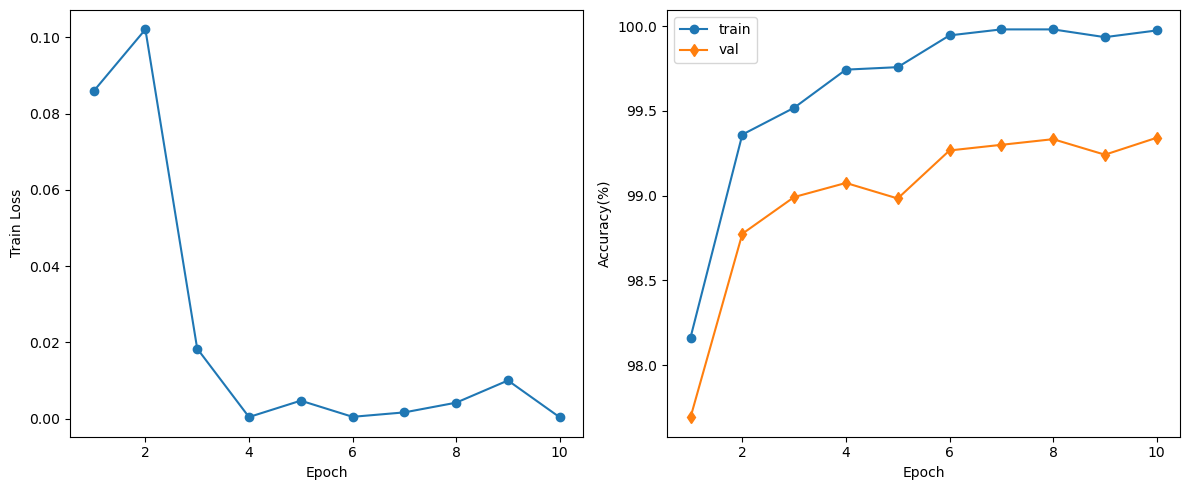

In [11]:
import matplotlib.pyplot as plt

fig_path = "../graph/DenseNet loss and acc.png"

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
epochs = [i + 1 for i in range(epochs)]
loss_values = [tensor.cpu().detach().numpy() for tensor in loss_values]
train_acc_values = np.array(train_acc_values) * 100
val_acc_values = np.array(val_acc_values) * 100

# 损失
axs[0].plot(epochs, loss_values, marker='o')

axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Train Loss')

# 准确率
axs[1].plot(epochs, train_acc_values, label='train', marker='o')
axs[1].plot(epochs, val_acc_values, label='val', marker='d')

axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy(%)')
axs[1].legend()

plt.tight_layout()
plt.savefig(fig_path)

In [12]:
def train_classifier_alt2(model, optimizer, epochs):
    model = model.to(device=device)
    for e in range(epochs):
        for t, (x, y) in enumerate(train_loader):
            model.train()
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # 将待更新参数的梯度置为零
            optimizer.zero_grad()

            # 反向传播，计算梯度
            loss.backward()

            # 利用梯度更新参数
            optimizer.step()
            
    val_acc = check_accuracy(val_loader, model)
    test_acc = check_accuracy(test_loader, model)
    
    return val_acc, test_acc

In [13]:
lr = 5e-3
momentum = 0.95
weight_decay = 0.0001
dropout = 0.0
epochs = 10

val_acc_values = []
test_acc_values = []

for _ in range(10):
    model = DenseNet(block_config=[6, 12, 24, 16], dropout=dropout)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=True, weight_decay=weight_decay)
    val_acc, test_acc = train_classifier_alt2(model, optimizer, epochs=epochs)
    val_acc_values.append(val_acc * 100)
    test_acc_values.append(test_acc * 100)
    
print("Validate: ", val_acc_values)
print("Test: ", test_acc_values)

Validate:  [99.425, 99.26666666666667, 99.34166666666667, 99.18333333333334, 99.325, 99.36666666666667, 99.20833333333333, 99.38333333333334, 99.40833333333333, 99.25]
Test:  [99.4, 99.42, 99.42, 99.25, 99.25, 99.44, 99.25, 99.22, 99.42999999999999, 99.38]
